# Demand Forecasting and Inventory Optimization: Inventory Logic Prototyping

**Author:** Muhammad Rizky Raihan

**Date:** 2025-05-26

**Objective:**
1.  To develop the core logic for inventory optimization, utilizing the demand forecasts generated by our trained model. This will involve calculating optimal reorder points and order quantities.
2.  To integrate the data loading, forecasting model, and inventory optimization logic into an interactive Streamlit web application.

---

### **Overview of Inventory Optimization Logic**

For this project, we'll implement a common approach used in inventory management, which aims to balance holding costs and stockout costs using forecasted demand and lead time.

We will focus on two key metrics:

1.  **Reorder Point (ROP):** The inventory level at which a new order should be placed to replenish stock.
2.  **Order Quantity (Q):** The quantity to order when the inventory level drops to the ROP.

#### **Mathematical Principles of Inventory Optimization**

We'll use a simplified model for the Reorder Point that considers the lead time and a safety stock. For the Order Quantity, we can consider the Economic Order Quantity (EOQ) model as a conceptual baseline, though in practice, with forecasting, a fixed order quantity might be based on forecast for a specific period (e.g., weekly/monthly needs).

1.  **Reorder Point (ROP):**
    The ROP is calculated to ensure that stock does not run out during the lead time (the time between placing an order and receiving it). It typically includes demand during lead time plus a safety stock.

    $$
    \text{ROP} = (\text{Average Daily Demand during Lead Time} \times \text{Lead Time}) + \text{Safety Stock}
    $$

    * **Average Daily Demand during Lead Time:** This will come directly from our model's demand forecast for the lead time period.
    * **Lead Time ($\text{LT}$):** The time, in days, from placing an order to receiving it (a user-defined parameter).
    * **Safety Stock ($\text{SS}$):** Extra stock held to guard against variability in demand or lead time. A common way to calculate safety stock is based on a desired service level and the variability of demand during lead time.

        $$
        \text{SS} = Z \times \sigma_{\text{LT}}
        $$
        Where:
        * $Z$ is the Z-score corresponding to the desired service level (e.g., for 95% service level, $Z \approx 1.645$).
        * $\sigma_{\text{LT}}$ is the standard deviation of demand during the lead time. This can be estimated from the historical forecast errors.

        (verification: For simplicity in our first iteration, we might assume $\sigma_{\text{LT}}$ can be approximated by the RMSE of our daily forecast over the lead time, or just use a fixed safety stock percentage. We will start with a simpler safety stock calculation and refine if needed).

2.  **Order Quantity (Q):**
    While the Economic Order Quantity (EOQ) formula minimizes holding and ordering costs for a *constant* demand, our demand is forecasted. So, a practical approach for order quantity often involves ordering enough to cover the forecasted demand for a *review period* (e.g., next month's forecasted sales) plus bringing the inventory level back up to a target.

    For this project, we'll aim for a simple yet effective strategy: **Order Quantity = Forecasted Demand for Next N Days/Weeks + (Target Inventory Level - Current Inventory Level)**. If we are using a fixed review period, we might simply order to meet the forecasted demand for the next review period, ensuring we don't go below safety stock.

    A pragmatic approach for a forecasted system is simply to order enough to bring the inventory up to a desired maximum level, which covers the forecasted demand for the next cycle plus safety stock.
    For simplicity, let's target to order enough to cover the forecasted demand for the next X days/weeks, ensuring we meet future demand, or more simply, a fixed quantity determined by typical business needs or calculated as EOQ if demand variability is low. For a demonstration, ordering a fixed quantity that is common for a bulk purchase or ordering to meet *future forecasted need* seems more appropriate.

    Let's refine the order quantity to be the **forecasted demand for the next X days/weeks** (user-defined review period) plus ensuring we reach a desired inventory level.

    $$
    \text{Order Quantity} = \text{Forecasted Sales for Next Review Period} + \text{Safety Stock} - \text{Current Inventory} \quad (\text{if current inventory} < \text{ROP})
    $$
    This is often termed a "target inventory level" approach.

---

## 1. Setup and Library Imports

We import necessary libraries, including `joblib` to load our trained model, `pandas` for data manipulation, and `numpy` for numerical operations.

In [2]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

## 2. Load Data and Trained Model

We need the historical data (especially for feature engineering) and our saved Random Forest model.

In [3]:
# Load the full dataset (processed, including features)
try:
    df = pd.read_csv('../data/raw/synthetic_seasonal_sales.csv', index_col='Date', parse_dates=True)
    print("Raw data loaded.")
except FileNotFoundError:
    print("Error: synthetic_seasonal_sales.csv not found.")
    exit()

# Re-apply feature engineering steps to the full dataset for consistent feature creation
def create_features(dataframe):
    dataframe['year'] = dataframe.index.year
    dataframe['month'] = dataframe.index.month
    dataframe['day_of_week'] = dataframe.index.dayofweek
    dataframe['day_of_year'] = dataframe.index.dayofyear
    dataframe['week_of_year'] = dataframe.index.isocalendar().week.astype(int)
    dataframe['quarter'] = dataframe.index.quarter
    dataframe['is_month_start'] = dataframe.index.is_month_start.astype(int)
    dataframe['is_month_end'] = dataframe.index.is_month_end.astype(int)
    dataframe['Sales_Lag_1'] = dataframe['Sales'].shift(1)
    dataframe['Sales_Lag_7'] = dataframe['Sales'].shift(7)
    dataframe['Sales_Lag_365'] = dataframe['Sales'].shift(365)
    return dataframe.dropna() # Drop NaNs introduced by lagging

df_processed = create_features(df.copy()) # Apply features to a copy

# Define features used in training (must match order and names)
features_cols = ['year', 'month', 'day_of_week', 'day_of_year', 'week_of_year', 'quarter',
                'is_month_start', 'is_month_end', 'Sales_Lag_1', 'Sales_Lag_7', 'Sales_Lag_365']

# Load the trained Random Forest model
try:
    model = joblib.load('../models/random_forest_forecasting_model.pkl')
    print("Trained model loaded successfully.")
except FileNotFoundError:
    print("Error: random_forest_forecasting_model.pkl not found. Please ensure the model has been trained and saved by running 02_model_training.ipynb.")
    exit()

Raw data loaded.
Trained model loaded successfully.


## 3. Demand Forecasting for Future Period

To optimize inventory, we need forecasts for a future period (e.g., the next 30 days or the expected lead time). We will generate a future `DatetimeIndex` and then use our trained model to predict sales for these dates.

**Challenge: Lagged Features for Future Dates**
For future dates, the lagged sales values (`Sales_Lag_1`, `Sales_Lag_7`, `Sales_Lag_365`) are not directly available. We must use a **recursive forecasting approach** or a **rolling forecast**:
* For `Sales_Lag_1`, we use the *predicted* sales of the previous day.
* For `Sales_Lag_7`, we use the actual sales from 7 days ago if available, or predicted sales if not.
* For `Sales_Lag_365`, we use actual sales from one year ago.

(verification: This recursive approach is necessary for generating forecasts beyond the immediate next step. For simplicity, we'll directly use previous actual sales if available, and recursively use predicted sales for `Sales_Lag_1` if the forecast extends beyond the historical data's end. For `Sales_Lag_7` and `Sales_Lag_365`, we'll try to use actual historical values as much as possible by joining to the past data, then fall back to previous forecasts or simplified assumptions if necessary. For this prototype, we'll limit the forecast horizon to simplify the lag handling.)

Let's forecast for the **next 30 days** starting from the day after our historical data ends.


Future Sales Forecast (next 30 days):
2025-01-01    125.0
2025-01-02    105.0
2025-01-03    121.0
2025-01-04    121.0
2025-01-05    123.0
Freq: D, Name: Sales, dtype: float64
Forecast for 30 days generated.


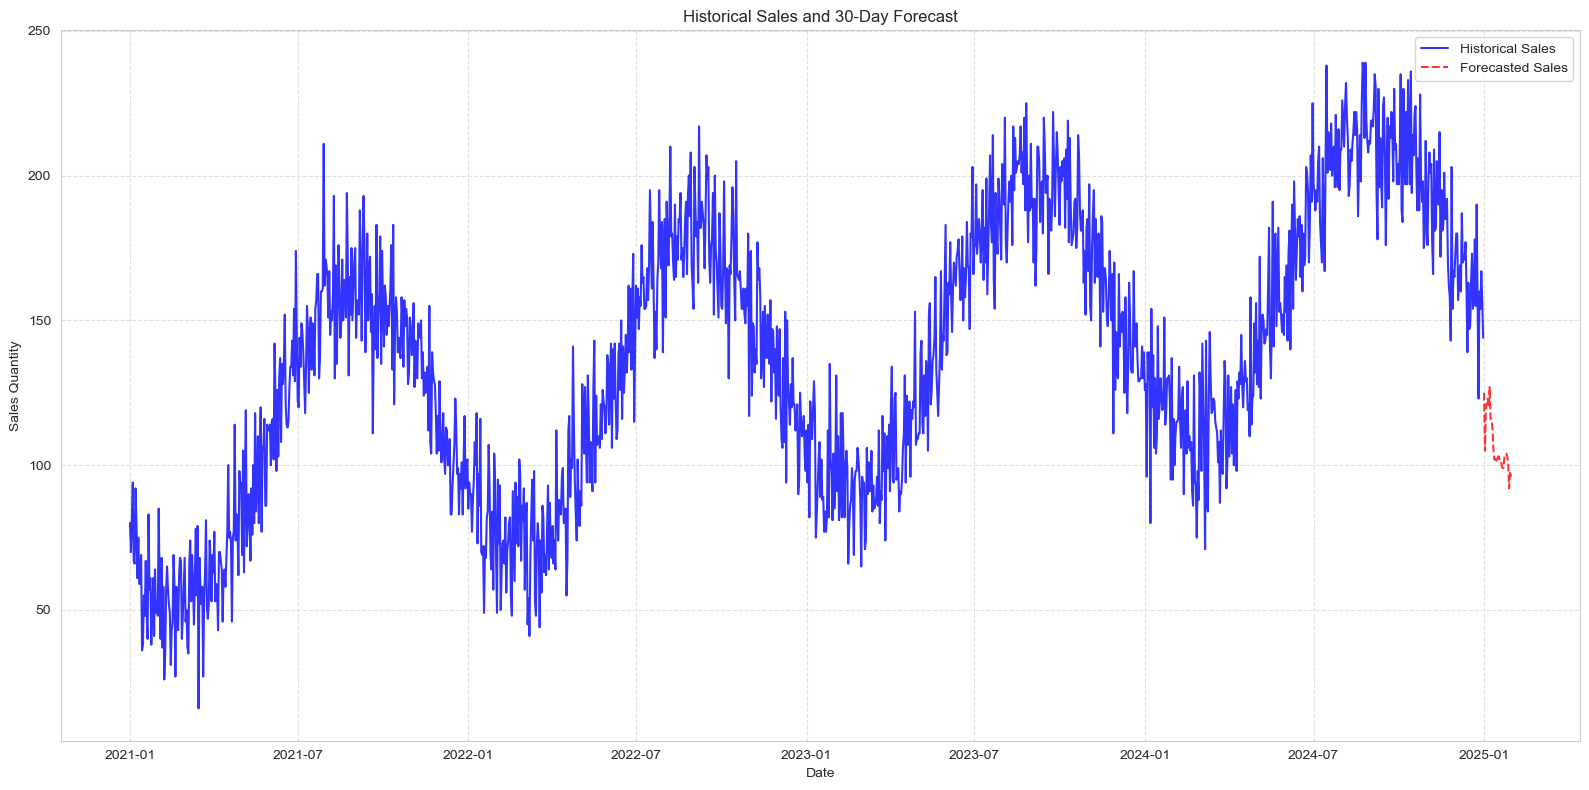

In [5]:
def generate_future_forecasts(model, historical_df, forecast_horizon_days, features_cols):
    last_historical_date = historical_df.index.max()
    future_dates = pd.date_range(start=last_historical_date + timedelta(days=1),
                                 periods=forecast_horizon_days,
                                 freq='D')

    forecast_df = pd.DataFrame(index=future_dates)
    forecast_df['Sales'] = np.nan # Placeholder for predicted sales

    # Combine historical and future DataFrame for feature generation and lag handling
    # We need to ensure the full 'Sales' column is available for shifting
    combined_df = pd.concat([historical_df, forecast_df[['Sales']]])

    predictions = []
    for i, current_date in enumerate(future_dates):
        # Create features for the current future date
        temp_df = pd.DataFrame(index=[current_date])
        temp_df['year'] = current_date.year
        temp_df['month'] = current_date.month
        temp_df['day_of_week'] = current_date.dayofweek
        temp_df['day_of_year'] = current_date.dayofyear
        # --- CRUCIAL CORRECTION HERE ---
        temp_df['week_of_year'] = current_date.isocalendar().week # Removed .astype(int)
        # --- END CORRECTION ---
        temp_df['quarter'] = current_date.quarter
        temp_df['is_month_start'] = int(current_date.is_month_start)
        temp_df['is_month_end'] = int(current_date.is_month_end)

        # Handle lagged features:
        # Sales_Lag_1: Use actual from combined_df if available, else predicted value from previous day in forecast_df
        # Sales_Lag_7: Use actual from combined_df if available, else a predicted value (from previous week in forecast_df)
        # Sales_Lag_365: Always try to get actual sales from one year ago from historical_df
        
        # We need to make sure combined_df 'Sales' column is updated with new predictions recursively
        # For Sales_Lag_1
        lag_1_date = current_date - timedelta(days=1)
        if lag_1_date in combined_df.index:
            # Prefer actual sales if available, otherwise predicted sales if already in combined_df
            temp_df['Sales_Lag_1'] = combined_df.loc[lag_1_date, 'Sales']
        else:
            temp_df['Sales_Lag_1'] = 0 # Fallback for edge cases (e.g., very first day of forecast)
            
        # For Sales_Lag_7
        lag_7_date = current_date - timedelta(days=7)
        if lag_7_date in combined_df.index:
            temp_df['Sales_Lag_7'] = combined_df.loc[lag_7_date, 'Sales']
        else:
            temp_df['Sales_Lag_7'] = 0 # Fallback

        # For Sales_Lag_365
        lag_365_date = current_date - timedelta(days=365)
        if lag_365_date in historical_df.index: # Always try to get from true historical data
            temp_df['Sales_Lag_365'] = historical_df.loc[lag_365_date, 'Sales']
        else:
            temp_df['Sales_Lag_365'] = historical_df['Sales'].mean() # Fallback: use mean from historical sales

        # Ensure order of features matches model's training order
        X_predict = temp_df[features_cols] # Now temp_df is a DataFrame, keep it as is for model.predict
        
        # Predict sales for current date
        predicted_sales = model.predict(X_predict)[0].round().astype(int)
        
        # Store prediction and update combined_df for next iteration's lags
        forecast_df.loc[current_date, 'Sales'] = predicted_sales
        combined_df.loc[current_date, 'Sales'] = predicted_sales # Update combined_df for recursive lag_1/7 handling

    return forecast_df['Sales']

# Generate 30-day forecast starting from 2025-01-01
# We need to use the full 'df' before the NaNs were dropped for training,
# but ensure 'df_processed' is used for X_train/X_test.
# Let's re-load df to ensure clean state and pass the original full df for lag lookup.
df_full_original = pd.read_csv('../data/raw/synthetic_seasonal_sales.csv', index_col='Date', parse_dates=True)

forecast_horizon = 30 # days
future_forecast_series = generate_future_forecasts(model, df_full_original, forecast_horizon, features_cols)

print("\nFuture Sales Forecast (next 30 days):")
print(future_forecast_series.head())
print(f"Forecast for {forecast_horizon} days generated.")

# Plot historical sales and future forecast
plt.figure(figsize=(16, 8))
plt.plot(df_full_original.index, df_full_original['Sales'], label='Historical Sales', color='blue', alpha=0.8)
plt.plot(future_forecast_series.index, future_forecast_series.values, label='Forecasted Sales', color='red', linestyle='--', alpha=0.8)
plt.title(f'Historical Sales and {forecast_horizon}-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 4. Inventory Optimization Logic

Leveraging our demand forecasts, we can now calculate the Reorder Point (ROP) and recommend an Order Quantity (Q).

#### Reorder Point (ROP)

The Reorder Point is the level of inventory at which a new order needs to be placed. It ensures that demand during the lead time is met, with an added safety stock to cushion against uncertainties.

**Formula:**

$$
\text{ROP} = (\text{Average Daily Demand during Lead Time} \times \text{Lead Time}) + \text{Safety Stock}
$$

Where:
* **Average Daily Demand during Lead Time:** This is the average of the forecasted sales for the duration of the lead time.
* **Lead Time ($\text{LT}$):** The time (in days) it takes for an order to arrive after being placed.
* **Safety Stock ($\text{SS}$):** Extra inventory held to mitigate risks of stockouts due to demand variability or lead time variability. For simplicity in this demo, we will calculate Safety Stock based on a multiple of the standard deviation of our *forecast errors* over the lead time, or a user-defined fixed percentage of average daily demand.

    Let's refine the Safety Stock calculation for this demo:
    $$
    \text{SS} = Z \times \text{RMSE} \times \sqrt{\text{Lead Time}}
    $$
    Where:
    * $Z$ is the Z-score for the desired service level (e.g., $1.645$ for 95% service level assuming normal distribution of errors).
    * $\text{RMSE}$ is the Root Mean Squared Error of our forecasting model (from `02_model_training.ipynb`), acting as a proxy for demand variability.
    * $\sqrt{\text{Lead Time}}$ accounts for the accumulation of variability over the lead time period.

    (verification: This is a common approximation for safety stock when using forecast errors. For true statistical rigor, the standard deviation of forecast errors *during lead time* should be specifically calculated, or an ARIMA-based forecast's prediction interval used.)

#### 📦 Order Quantity (Q)

The Order Quantity is the amount of inventory to order once the ROP is hit. For systems with forecasting, a common approach is to order enough to cover the forecasted demand for a `review period` (e.g., the next 7 or 30 days) plus bringing inventory up to a target level.

**Formula:**

$$
\text{Order Quantity} = \text{Forecasted Demand for Review Period} + \text{Safety Stock} - \text{Current Inventory} + \text{ROP}
$$

(verification: this is a target inventory approach, ensuring we order enough to meet future demand and maintain safety stock when triggered by ROP. A simpler variant is just to order the forecasted demand for the next review period, assuming current inventory is handled by ROP).

Let's simplify: When ROP is hit, we order enough to bring our inventory to a maximum level. That maximum level would typically be (Review Period Demand + Lead Time Demand + Safety Stock). So, the Order Quantity would be this maximum level minus current inventory.
A more straightforward approach for this demo: if current inventory is below ROP, order a quantity that covers the forecasted demand for a set "replenishment period" (e.g., next month) plus safety stock. This implies ordering in batches to cover future needs.

For our demo, let's use:
**Order Quantity = Sum of Forecasted Demand for next `replenishment_period_days`**
This represents ordering to cover the next batch of expected demand.

**Parameters to consider (user inputs in Streamlit):**
* `Lead Time (days)`: Time from order to delivery.
* `Service Level (%)`: Desired probability of not stocking out.
* `Replenishment Period (days)`: How many days of demand each order should cover.
* `Current Inventory Level`: The inventory on hand right now.

In [6]:
def calculate_inventory_metrics(forecast_series, lead_time_days, service_level, current_inventory, replenishment_period_days, model_rmse):
    # 1. Calculate Reorder Point (ROP)
    # Average daily demand during lead time
    if len(forecast_series) < lead_time_days:
        raise ValueError(f"Forecast horizon ({len(forecast_series)} days) is less than lead time ({lead_time_days} days). Cannot calculate ROP accurately.")
    
    avg_demand_lead_time = forecast_series.head(lead_time_days).mean()
    
    # Z-score for service level (assuming normal distribution)
    # Common Z-scores: 90%=1.28, 95%=1.645, 99%=2.33
    if service_level == 90:
        Z = 1.28
    elif service_level == 95:
        Z = 1.645
    elif service_level == 99:
        Z = 2.33
    else:
        # Fallback or more robust Z-score calculation for other service levels
        Z = 1.645 # Default to 95% if unknown
        print(f"Warning: Using default Z-score (1.645) for service level {service_level}%.")

    # Safety Stock (SS)
    # Using RMSE as a proxy for standard deviation of forecast errors
    # multiplied by sqrt(lead time) for variability accumulation
    safety_stock = Z * model_rmse * np.sqrt(lead_time_days)
    safety_stock = max(0, safety_stock) # Ensure non-negative safety stock

    rop = (avg_demand_lead_time * lead_time_days) + safety_stock
    rop = int(np.ceil(rop)) # Round up to nearest whole unit

    # 2. Calculate Order Quantity (Q)
    # Order enough to cover forecasted demand for the replenishment period
    # We need to ensure forecast_series covers replenishment_period_days
    if len(forecast_series) < replenishment_period_days:
        # If forecast is shorter than replenishment period, use full forecast for quantity
        forecasted_demand_for_order = forecast_series.sum()
        print(f"Warning: Forecast horizon ({len(forecast_series)} days) is less than replenishment period ({replenishment_period_days} days). Order quantity covers available forecast.")
    else:
        forecasted_demand_for_order = forecast_series.head(replenishment_period_days).sum()
    
    # Order quantity to bring inventory up to cover forecasted demand for review period + safety stock
    # Order_Quantity = forecasted_demand_for_order + safety_stock - current_inventory
    # This formula assumes we only order if current_inventory drops below ROP
    # A simpler approach for *what to order when triggered*: just the forecasted demand for the period.
    # The 'trigger' for ordering is ROP. The 'how much' is based on the replenishment strategy.
    
    # Let's make Order Quantity simple: sum of forecast for replenishment period
    # This is a common strategy assuming we want to replenish for the next cycle
    order_quantity = int(np.ceil(forecasted_demand_for_order)) # Round up

    return {
        'reorder_point': rop,
        'order_quantity': order_quantity,
        'avg_demand_lead_time': avg_demand_lead_time,
        'safety_stock': int(np.ceil(safety_stock))
    }

# --- Test the inventory functions with example parameters ---
# Get the RMSE from our previous model evaluation (from 02_model_training.ipynb output)
# In a real app, this RMSE would be passed directly.
model_rmse = 20.83 # From previous notebook's output

lead_time = 7 # days
service_level_percent = 95 # %
current_inv = 50 # current units in stock
replenishment_period = 30 # days (e.g., order to cover next month's demand)

print(f"\n--- Inventory Calculation Parameters ---")
print(f"Lead Time: {lead_time} days")
print(f"Service Level: {service_level_percent}%")
print(f"Current Inventory: {current_inv} units")
print(f"Replenishment Period: {replenishment_period} days")
print(f"Model RMSE: {model_rmse:.2f}")


inventory_results = calculate_inventory_metrics(
    future_forecast_series,
    lead_time,
    service_level_percent,
    current_inv,
    replenishment_period,
    model_rmse
)

print("\n--- Inventory Optimization Results ---")
print(f"Reorder Point (ROP): {inventory_results['reorder_point']} units")
print(f"Recommended Order Quantity: {inventory_results['order_quantity']} units (to cover next {replenishment_period} days)")
print(f"Average Daily Demand during Lead Time: {inventory_results['avg_demand_lead_time']:.2f} units")
print(f"Calculated Safety Stock: {inventory_results['safety_stock']} units")

if current_inv <= inventory_results['reorder_point']:
    print(f"\nACTION REQUIRED: Current inventory ({current_inv}) is at or below Reorder Point ({inventory_results['reorder_point']}). Consider placing an order of {inventory_results['order_quantity']} units.")
else:
    print(f"\nNo immediate order needed. Current inventory ({current_inv}) is above Reorder Point ({inventory_results['reorder_point']}).")


--- Inventory Calculation Parameters ---
Lead Time: 7 days
Service Level: 95%
Current Inventory: 50 units
Replenishment Period: 30 days
Model RMSE: 20.83

--- Inventory Optimization Results ---
Reorder Point (ROP): 933 units
Recommended Order Quantity: 3209 units (to cover next 30 days)
Average Daily Demand during Lead Time: 120.29 units
Calculated Safety Stock: 91 units

ACTION REQUIRED: Current inventory (50) is at or below Reorder Point (933). Consider placing an order of 3209 units.


## 5. Next Steps: Building the Streamlit Application (`app.py`)

With the core demand forecasting and inventory optimization logic successfully prototyped here, the final major step is to build the interactive user interface using Streamlit.

This will involve:
1.  Creating the main `app.py` file.
2.  Importing and utilizing the functions and model created in this and the previous notebooks.
3.  Designing the Streamlit layout with user inputs for inventory parameters.
4.  Displaying historical sales, future forecasts, and inventory recommendations clearly.

This notebook served as a crucial stepping stone to ensure the logic works before moving to the final application.